General Comments of the provided code: 
    
Dataset used:
SMS Spam Collection Dataset
https://www.kaggle.com/uciml/sms-spam-collection-dataset 
    
    
Cost-Sensitive Learning approaches :

1.Minimizing the cost (with Bayes-Minimum-Risk-Classifier model and other similar models):

        - Without calibration 
        - With sigmoid calibration 
        - With isotonic calibration 
        
2.Stratification aka Rebalancing: 

        -With Under-Sampling 
        -With Over – Sampling
        -With Combination 
        
3.Example Weighting 

The code is accompanied with a comprehensive report where the results are analyzed and futher insights about the 
conclusions of the aforementioned approaches are given

Happy reading and feel free to contact us for any further details



In [1]:
#import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from costcla.metrics import cost_loss
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
from sklearn.metrics import balanced_accuracy_score
import math
from sklearn.calibration import CalibratedClassifierCV
from costcla.models import BayesMinimumRiskClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

C:\Users\nickg\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classe

In [2]:
# timing of the code 

import time
start_time = time.time()

In [3]:
# Loading my data 

sms = pd.read_csv("spam_data.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Data preprocessing 

In [4]:
sms.describe() 

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [5]:
# we have an imbalace of spam/ham ~= 1/7 
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [6]:
# convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
sms.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
#check message lenghts 
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

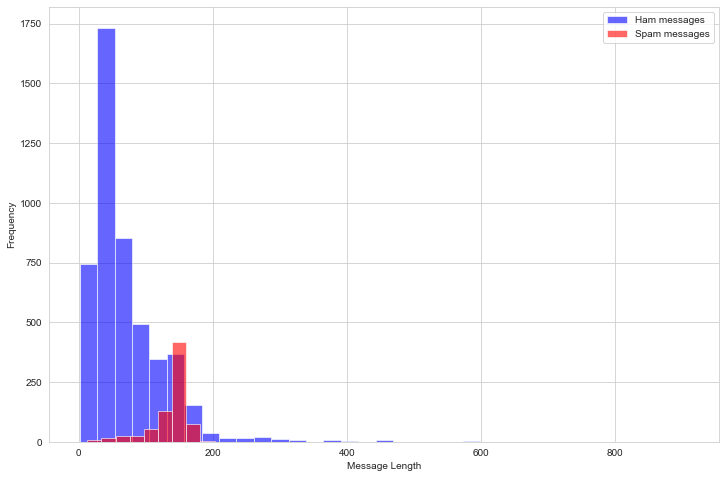

In [8]:
# visualize the imbalance in correlation with message lenght 
# it seems that spam messages tend to have more characters
plt.figure(figsize=(12, 8))

sms[sms.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
sms[sms.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [9]:
#mean of ham messages = 71 
sms[sms.label=='ham'].describe()

,label_num,message_len
count,4825.0,4825.000000
mean,0.0,71.023627
std,0.0,58.016023
min,0.0,2.000000
25%,0.0,33.000000
50%,0.0,52.000000
75%,0.0,92.000000
max,0.0,910.000000


In [10]:
#mean of spam messages = 138 
sms[sms.label=='spam'].describe()

,label_num,message_len
count,747.0,747.000000
mean,1.0,138.866131
std,0.0,29.183082
min,1.0,13.000000
25%,1.0,132.500000
50%,1.0,149.000000
75%,1.0,157.000000
max,1.0,224.000000


In [11]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [12]:
# apply the tokenization
sms['clean_msg'] = sms.message.apply(text_process)

In [13]:
#check our dataset now
sms.head()

,label,message,label_num,message_len,clean_msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,Nah think goes usf lives around though


In [14]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = sms.clean_msg
y = sms.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [15]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4179,)
(1393,)
(4179,)
(1393,)


In [16]:
# vectorization 

# instantiate the vectorizer
# vect = CountVectorizer()
#tuned vectorizer 
vect = CountVectorizer(max_features=1500, max_df=0.85, stop_words=stopwords.words("english"))
#fit and transform 
X_train = vect.fit_transform(X_train)
# examine the document-term matrix
X_train

<4179x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 25645 stored elements in Compressed Sparse Row format>

In [17]:
# transform testing data into a document-term matrix
X_test = vect.transform(X_test)
X_test

<1393x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 8088 stored elements in Compressed Sparse Row format>

In [18]:
#tf_idf
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train)
tfidf_transformer.transform(X_train)

<4179x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 25645 stored elements in Compressed Sparse Row format>

Cost Matrix 

In [19]:
#fp, fn, tp, tn
fp = np.full((y_test.shape[0],1), 10)
fn = np.full((y_test.shape[0],1), 1)
tp = np.zeros((y_test.shape[0],1))
tn = np.zeros((y_test.shape[0],1))
cost_matrix = np.hstack((fp, fn, tp, tn))

Random Forest comparisons 

In [20]:
print("Baseline Random Forest ")
clf = RandomForestClassifier(random_state=0, n_estimators=100, max_depth = 70)
model = clf.fit(X_train, y_train)
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T)
print('\n')

print("Random Forest with example weighting")
clf = RandomForestClassifier(random_state=0, n_estimators=100, max_depth = 70, class_weight = {0: 1, 1: 10})
# clf = RandomForestClassifier(random_state=0, n_estimators=100, max_depth = 70, class_weight = 'balanced')
model = clf.fit(X_train, y_train)
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T)
print('\n')

print("RandomForest and Bayes Minimum Risk with no calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100,  max_depth = 70)
model = clf.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("\n RandomForest and Bayes Minimum Risk with sigmoid calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100,  max_depth = 70)
cc = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("\n RandomForest and Bayes Minimum Risk with isotonic calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100,  max_depth = 70)
cc = CalibratedClassifierCV(clf, method="isotonic", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("Random Forest with undersampling")
clf = RandomForestClassifier(random_state=0, n_estimators=100,  max_depth = 70)
sampler = RandomUnderSampler(sampling_strategy={0: 3619, 1: 362}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print('\n')

print("Random Forest with oversampling")
clf = RandomForestClassifier(random_state=0, n_estimators=100,  max_depth = 70)
sampler = RandomOverSampler(sampling_strategy={0: 5600, 1: 560}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)

print("Random Forest with combination")
clf = RandomForestClassifier(random_state=0, n_estimators=100,  max_depth = 70)
sampler = RandomUnderSampler(sampling_strategy={0: 3619, 1: 450}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
sampler = RandomOverSampler(sampling_strategy={0: 4500, 1: 450}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_rs, y_rs)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)



Baseline Random Forest 
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.97      0.85      0.91       187

    accuracy                           0.98      1393
   macro avg       0.97      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393

78

[[1201   28]
 [   5  159]]


Random Forest with example weighting
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.98      0.84      0.90       187

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393

60

[[1203   30]
 [   3  157]]


RandomForest and Bayes Minimum Risk with no calibration
              precision    recall  f1-score   support

         ham       0.92      1.00      0.96      1206
        spam       1.00      0.45      0.62       187


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1206
        spam       0.99      0.73      0.84       187

    accuracy                           0.96      1393
   macro avg       0.98      0.87      0.91      1393
weighted avg       0.96      0.96      0.96      1393

[[1205   50]
 [   1  137]]
60



Random Forest with oversampling
Counter({0: 5600, 1: 560})


C:\Users\nickg\anaconda3\lib\site-packages\imblearn\utils\_validation.py:257: UserWarning: After over-sampling, the number of samples (5600) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3619)
  n_samples_majority))
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.98      0.86      0.91       187

    accuracy                           0.98      1393
   macro avg       0.98      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[[1203   27]
 [   3  160]]
57

Random Forest with combination
Counter({0: 4500, 1: 450})


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nickg\anaconda3\lib\site-packages\imblearn\utils\_validation.py:257: UserWarning: After over-sampling, the number of samples (4500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3619)
  n_samples_majority))


              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1206
        spam       0.99      0.80      0.88       187

    accuracy                           0.97      1393
   macro avg       0.98      0.90      0.93      1393
weighted avg       0.97      0.97      0.97      1393

[[1204   38]
 [   2  149]]
58



SVM comparisons 

In [21]:
print("Baeline SVM")
clf = SVC(kernel='linear', C=1, probability=True)
model = clf.fit(X_train, y_train)
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test,target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) #transpose 
print('\n')


print("SVM with example weighting")
# clf = SVC(kernel='linear', C=1, probability=True, class_weight = {0: 1, 1: 10})
clf = SVC(kernel='linear', C=1, probability=True, class_weight = {0: 10, 1: 1})
# clf = SVC(kernel='linear', C=1, probability=True, class_weight = 'balanced')
model = clf.fit(X_train, y_train)
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test,target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) #transpose 
print('\n')

print("SVM and Bayes Minimum Risk with no calibration")
clf = SVC(kernel='linear', C=1, probability=True)
model = clf.fit(X_train, y_train)
prob_train = model.predict_proba(X_train)
bmr = BayesMinimumRiskClassifier(calibration=False)
bmr.fit(y_train, prob_train) 
prob_test = model.predict_proba(X_test)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("\n SVM and Bayes Minimum Risk with sigmoid calibration")
clf = SVC(kernel='linear', C=1, probability=True)
cc = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("SVM and Bayes Minimum Risk with isotonic calibration")
clf = SVC(kernel='linear', C=1, probability=True)
cc = CalibratedClassifierCV(clf, method="isotonic", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')


print("SVM with undersampling")
clf = SVC(kernel='linear', C=1, probability=True)
sampler = RandomUnderSampler(sampling_strategy={0: 3619, 1: 362}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print('\n')

print("SVM with oversampling")
clf = SVC(kernel='linear', C=1, probability=True)
sampler = RandomOverSampler(sampling_strategy={0: 5600, 1: 560}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)

print("SVM with combination")
clf = SVC(kernel='linear', C=1, probability=True)
sampler = RandomUnderSampler(sampling_strategy={0: 3619, 1: 450}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
sampler = RandomOverSampler(sampling_strategy={0: 4500, 1: 450}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_rs, y_rs)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)

Baeline SVM
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.98      0.88      0.93       187

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393

62

[[1202   22]
 [   4  165]]


SVM with example weighting
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.98      0.87      0.92       187

    accuracy                           0.98      1393
   macro avg       0.98      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393

64

[[1202   24]
 [   4  163]]


SVM and Bayes Minimum Risk with no calibration
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1206
        spam       1.00      0.79      0.88       187

    accuracy                  

C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.99      0.85      0.92       187

    accuracy                           0.98      1393
   macro avg       0.99      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[[1205   28]
 [   1  159]]
38



SVM with oversampling
Counter({0: 5600, 1: 560})


C:\Users\nickg\anaconda3\lib\site-packages\imblearn\utils\_validation.py:257: UserWarning: After over-sampling, the number of samples (5600) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3619)
  n_samples_majority))
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.98      0.89      0.93       187

    accuracy                           0.98      1393
   macro avg       0.98      0.94      0.96      1393
weighted avg       0.98      0.98      0.98      1393

[[1202   21]
 [   4  166]]
61

SVM with combination
Counter({0: 4500, 1: 450})


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nickg\anaconda3\lib\site-packages\imblearn\utils\_validation.py:257: UserWarning: After over-sampling, the number of samples (4500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3619)
  n_samples_majority))


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.98      0.87      0.92       187

    accuracy                           0.98      1393
   macro avg       0.98      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[[1203   25]
 [   3  162]]
55



Logistic Regression Comparisons 

In [22]:
print("Baseline Logistic Regression ")
clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1) 
# clf = LogisticRegression()
model = clf.fit(X_train, y_train)
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test,target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("Logistic Regression with example weighting")
clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1, class_weight = {0:10, 1:1}) 
# clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1, class_weight = 'balanced')
clf = LogisticRegression()
model = clf.fit(X_train, y_train)
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test,target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("Logistic Regression and Bayes Minimum Risk with no calibration")
clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1) 
# clf = LogisticRegression()
model = clf.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
# print(prob_test)
#A example-dependent cost-sensitive binary Bayes minimum risk classifier.
# http://albahnsen.github.io/CostSensitiveClassification/BayesMinimumRiskClassifier.html 
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
# print(pred_test)
print(classification_report(y_test, pred_test,target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("\n Logistic Regression and Bayes Minimum Risk with sigmoid calibration")
clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1)
# clf = LogisticRegression()
cc = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test,target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose
print('\n')


print("Logistic Regression and Bayes Minimum Risk with isotonic calibration")
clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1)
# clf = LogisticRegression()
cc = CalibratedClassifierCV(clf, method="isotonic", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')


print("Logistic Regression with undersampling")
clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1)
# clf = LogisticRegression()
sampler = RandomUnderSampler(sampling_strategy={0: 3619, 1: 362}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print('\n')


print("Logistic Regression with oversampling")
clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1)
# clf = LogisticRegression()
sampler = RandomOverSampler(sampling_strategy={0: 5600, 1: 560}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print('\n')


print("Logistic Regression with combination")
clf = LogisticRegression(solver='saga', penalty = 'elasticnet', max_iter = 40, l1_ratio=1)
# clf = LogisticRegression()
sampler = RandomUnderSampler(sampling_strategy={0: 3619, 1: 450}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
sampler = RandomOverSampler(sampling_strategy={0: 4500, 1: 450}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_rs, y_rs)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print('\n')

Baseline Logistic Regression 


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.99      0.86      0.92       187

    accuracy                           0.98      1393
   macro avg       0.98      0.93      0.95      1393
weighted avg       0.98      0.98      0.98      1393

46

[[1204   26]
 [   2  161]]


Logistic Regression with example weighting
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       1.00      0.86      0.92       187

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393

27

[[1206   27]
 [   0  160]]


Logistic Regression and Bayes Minimum Risk with no calibration


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

         ham       0.93      1.00      0.96      1206
        spam       1.00      0.50      0.66       187

    accuracy                           0.93      1393
   macro avg       0.96      0.75      0.81      1393
weighted avg       0.94      0.93      0.92      1393

94

[[1206   94]
 [   0   93]]



 Logistic Regression and Bayes Minimum Risk with sigmoid calibration


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1206
        spam       1.00      0.66      0.79       187

    accuracy                           0.95      1393
   macro avg       0.97      0.83      0.88      1393
weighted avg       0.96      0.95      0.95      1393

64

[[1206   64]
 [   0  123]]


Logistic Regression and Bayes Minimum Risk with isotonic calibration


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1206
        spam       1.00      0.70      0.82       187

    accuracy                           0.96      1393
   macro avg       0.98      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393

56

[[1206   56]
 [   0  131]]


Logistic Regression with undersampling
Counter({0: 3619, 1: 362})


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\nickg\anaconda3\lib\site-packages\imblearn\utils\_validation.py:257: UserWarning: After over-sampling, the number of samples (5600) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3619)
  n_samples_majority))
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1206
        spam       0.99      0.79      0.88       187

    accuracy                           0.97      1393
   macro avg       0.98      0.90      0.93      1393
weighted avg       0.97      0.97      0.97      1393

[[1205   39]
 [   1  148]]
49



Logistic Regression with oversampling
Counter({0: 5600, 1: 560})


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nickg\anaconda3\lib\site-packages\imblearn\utils\_validation.py:257: UserWarning: After over-sampling, the number of samples (4500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3619)
  n_samples_majority))


              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.99      0.84      0.91       187

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393

[[1205   30]
 [   1  157]]
40



Logistic Regression with combination
Counter({0: 4500, 1: 450})
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1206
        spam       1.00      0.82      0.90       187

    accuracy                           0.98      1393
   macro avg       0.99      0.91      0.94      1393
weighted avg       0.98      0.98      0.97      1393

[[1206   34]
 [   0  153]]
34





C:\Users\nickg\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Multinomial Naive Bayes Comparisons

In [23]:
print("Baseline MultinomialNB")
clf = MultinomialNB()
model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print('\n')

print("MultinomialNB with example weighting")
clf = MultinomialNB(class_prior = [10,1])
model = clf.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')

print("MultinomialNB and Bayes Minimum Risk with no calibration")
clf = MultinomialNB()
model = clf.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')


print("\n MultinomialNB and Bayes Minimum Risk with sigmoid calibration")
clf = MultinomialNB()
cc = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')


print("MultinomialNB and Bayes Minimum Risk with isotonic calibration")
clf = MultinomialNB()
cc = CalibratedClassifierCV(clf, method="isotonic", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names = ['ham', 'spam']))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose 
print('\n')



print("MultinomialNB with undersampling")
sampler = RandomUnderSampler(sampling_strategy={0: 3619, 1: 362}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print('\n')

print("MultinomialNB with oversampling")
sampler = RandomOverSampler(sampling_strategy={0: 5600, 1: 560}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print('\n')

print("MultinomialNB with combination")
sampler = RandomUnderSampler(sampling_strategy={0: 3619, 1: 450}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_train, y_train)
sampler = RandomOverSampler(sampling_strategy={0: 4500, 1: 450}, random_state=0)
X_rs, y_rs = sampler.fit_resample(X_rs, y_rs)
print(Counter(y_rs))
model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)

Baseline MultinomialNB
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1206
        spam       0.96      0.90      0.93       187

    accuracy                           0.98      1393
   macro avg       0.97      0.95      0.96      1393
weighted avg       0.98      0.98      0.98      1393

[[1199   18]
 [   7  169]]
88



MultinomialNB with example weighting
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       1.00      0.84      0.91       187

    accuracy                           0.98      1393
   macro avg       0.99      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393

30

[[1206   30]
 [   0  157]]


MultinomialNB and Bayes Minimum Risk with no calibration
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1206
        spam       0.99      0.85      0.91       187


C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nickg\anaconda3\lib\site-packages\imblearn\utils\_validation.py:257: UserWarning: After over-sampling, the number of samples (5600) in class 0 will be larger than the number of samples in the majority class (class #0 -> 3619)
  n_samples_majority))
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nickg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, c

In [24]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.694284677505493 seconds ---
